#### VARIABLES

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
basepath = "dades_tfg/data"
demographics = pd.read_csv(os.path.join(basepath, "demographics.csv"))
demographics_N = pd.read_csv(os.path.join(basepath, "demographics_N.csv"))
nodes = pd.read_csv(os.path.join(basepath, "nodes.csv"))
basepath_FA = os.path.join(basepath, "FA")
basepath_GM = os.path.join(basepath, "GM")
basepath_RS = os.path.join(basepath, "RS")

In [3]:
filenames = ["{:04d}.csv".format(x) for x in demographics["id"]]

In [4]:
data_FA = np.zeros(shape=(len(filenames), 76, 76))
data_GM = np.zeros(shape=(len(filenames), 76, 76))
data_RS = np.zeros(shape=(len(filenames), 76, 76))

In [5]:
for i, filename in enumerate(filenames):
    df_FA = pd.read_csv(os.path.join(basepath_FA, filename), header=None)
    data_FA[i,:,:] = df_FA.values
    
    df_GM = pd.read_csv(os.path.join(basepath_GM, filename), header=None)
    data_GM[i,:,:] = df_GM.values
    
    df_RS = pd.read_csv(os.path.join(basepath_RS, filename), header=None)
    data_RS[i,:,:] = df_RS.values

In [6]:
basepath_FA_N = "dades_tfg/data/Naples/DTI_networks"
basepath_GM_N = "dades_tfg/data/Naples/GM_networks"
basepath_RS_N = "dades_tfg/data/Naples/rsfmri_networks"

# Listar nombres de archivos CSV en cada carpeta
filenames_FA_N = sorted([f for f in os.listdir(basepath_FA_N) if f.endswith('.csv')])
filenames_GM_N = sorted([f for f in os.listdir(basepath_GM_N) if f.endswith('.csv')])
filenames_RS_N = sorted([f for f in os.listdir(basepath_RS_N) if f.endswith('.csv')])

In [7]:
# Inicializar arrays para almacenar los datos
data_FA_N = np.zeros((len(filenames_FA_N), 76, 76))  
data_GM_N = np.zeros((len(filenames_GM_N), 76, 76))
data_RS_N = np.zeros((len(filenames_RS_N), 76, 76))

In [8]:
# FA
for i, filename in enumerate(filenames_FA_N):
    df_FA_N = pd.read_csv(os.path.join(basepath_FA_N, filename), header=None)
    data_FA_N[i, :, :] = df_FA_N.values

#  GM
for i, filename in enumerate(filenames_GM_N):
    df_GM_N = pd.read_csv(os.path.join(basepath_GM_N, filename), header=None)
    data_GM_N[i, :, :] = df_GM_N.values

#  RS
for i, filename in enumerate(filenames_RS_N):
    df_RS_N = pd.read_csv(os.path.join(basepath_RS_N, filename), header=None)
    data_RS_N[i, :, :] = df_RS_N.values

In [9]:
num_samples_FA = len(data_FA)
num_samples_FA_N = len(data_FA_N)
num_samples_GM = len(data_FA)
num_samples_GM_N = len(data_FA_N)
num_samples_RS = len(data_FA)
num_samples_RS_N = len(data_FA_N)


data_FA_combined = np.zeros((num_samples_FA + num_samples_FA_N, 76, 76))  
data_FA_combined[:num_samples_FA, :, :] = data_FA
data_FA_combined[num_samples_FA:, :, :] = data_FA_N


data_GM_combined = np.zeros((num_samples_GM + num_samples_GM_N, 76, 76))  
data_GM_combined[:num_samples_GM, :, :] = data_GM
data_GM_combined[num_samples_GM:, :, :] = data_GM_N


data_RS_combined = np.zeros((num_samples_RS + num_samples_RS_N, 76, 76))  
data_RS_combined[:num_samples_RS, :, :] = data_RS
data_RS_combined[num_samples_RS:, :, :] = data_RS_N

In [10]:
demographics_N['mstype'] = demographics_N['mstype'].apply(lambda x: 0 if x == -1 else 1)

# Embeddings

In [11]:
from gensim.models.word2vec import Word2Vec
#!pip install node2vec
from node2vec import Node2Vec

### EMBEDDING POR REGIÓN CEREBRAL

In [12]:
regions_sequences = []

for i in range(len(data_FA_combined)):
    fa_str = f"fa_{data_FA_combined[i].mean():.4f}"
    gm_str = f"gm_{data_GM_combined[i].mean():.4f}"
    rs_str = f"rs_{data_RS_combined[i].mean():.4f}"
    regions_sequences.append([fa_str, gm_str, rs_str])

# Entrenar Word2Vec per les regions (fila -> regio, paraula -> característica)
region_model = Word2Vec(sentences=regions_sequences,
                        vector_size=10,  # Tamaño de los embeddings
                        window=3,        # Contexto de ventana
                        min_count=1,     # Mínima frecuencia
                        sg=1,            # Skip-gram
                        workers=4,       # Número de threads
                        seed=42)

# Verificar
word_to_check = 'fa_0.2402'
if word_to_check in region_model.wv:
    example_region_embedding = region_model.wv[word_to_check]
    print(f"Embedding for '{word_to_check}': {example_region_embedding}")
else:
    print(f"Key '{word_to_check}' not present in the vocabulary.")


Embedding for 'fa_0.2402': [ 0.05953992 -0.06183975 -0.00803814 -0.07406999  0.03762425 -0.00474666
 -0.03430344 -0.05558663  0.01260491  0.03407322]


### EMBEDDING POR INDIVIDUO

In [13]:
individual_sequences = []

num_regions_per_individual = 76

for i in range(0, data_FA_combined.shape[0], num_regions_per_individual):
    individual_data = []
    for j in range(num_regions_per_individual):
        idx = i + j
        if idx < data_FA_combined.shape[0]:
            fa_str = f"fa_{data_FA_combined[idx].mean():.4f}"
            gm_str = f"gm_{data_GM_combined[idx].mean():.4f}"
            rs_str = f"rs_{data_RS_combined[idx].mean():.4f}"
            individual_data.extend([fa_str, gm_str, rs_str])
    individual_sequences.append(individual_data)

#document -> 1 individu embedding x individu
individual_model = Word2Vec(sentences=individual_sequences,
                            vector_size=50,
                            window=5,
                            min_count=1,
                            sg=1,
                            workers=4,
                            seed=42)

# Verificar
example_individual_embedding = individual_model.wv['fa_0.2402']
print(example_individual_embedding)


[ 0.00113606 -0.01888139 -0.00772895 -0.00244514  0.01910514  0.02018554
 -0.01384227  0.01609786 -0.0171045   0.01069989  0.01315454  0.01580461
 -0.01115625  0.01704938 -0.01540964  0.00076591 -0.00086626 -0.00786031
 -0.01999719  0.01112008 -0.00636248  0.00671529 -0.00403518 -0.00518628
  0.01562859 -0.0161751   0.0092443   0.01025486 -0.00535387 -0.01025156
 -0.01987389  0.01697585  0.01776912 -0.01018531 -0.01909557 -0.01521568
 -0.01727444  0.01202455  0.01641897 -0.01382851  0.00974878 -0.01204344
 -0.0045702   0.00311581  0.00918622  0.01478828 -0.01842475 -0.01187794
 -0.00891993 -0.00797611]


### RANDOMWALK Y DEEPWALK

In [14]:
import networkx as nx

In [15]:
def calculate_threshold(matrix):
    weights = matrix.values.flatten()
    mean_weight = weights.mean()
    std_weight = weights.std()
    median_weight = np.median(weights)
    threshold = mean_weight + std_weight  # media + 2 * std # mirar-ho amb la median i tornar mirar la FA
    return threshold

def create_graph_with_threshold(adj_matrix, nodes, threshold):
    G = nx.Graph()
    for index, row in nodes.iterrows():
        G.add_node(row['region_id'], name=row['region_name'])
    for i in range(adj_matrix.shape[0]):
        for j in range(i + 1, adj_matrix.shape[1]):
            if adj_matrix.iloc[i, j] > threshold:  # mayor q threshold
                G.add_edge(i+1, j+1, weight=adj_matrix.iloc[i, j])
    return G

In [16]:
graphs_FA = []

for i in range(data_FA_combined.shape[0]):
    print(f"Loading data_FA_combined[{i}]")
    adj_matrix = pd.DataFrame(data_FA_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_FA = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_FA.number_of_nodes()} nodos, {G_FA.number_of_edges()} aristas")

    graphs_FA.append(G_FA)

Loading data_FA_combined[0]
   Threshold = 0.4428
Grafo creado para muestra 0: 76 nodos, 505 aristas
Loading data_FA_combined[1]
   Threshold = 0.4126
Grafo creado para muestra 1: 76 nodos, 439 aristas
Loading data_FA_combined[2]
   Threshold = 0.4698
Grafo creado para muestra 2: 76 nodos, 497 aristas
Loading data_FA_combined[3]
   Threshold = 0.4459
Grafo creado para muestra 3: 76 nodos, 469 aristas
Loading data_FA_combined[4]
   Threshold = 0.4144
Grafo creado para muestra 4: 76 nodos, 476 aristas
Loading data_FA_combined[5]
   Threshold = 0.4652
Grafo creado para muestra 5: 76 nodos, 437 aristas
Loading data_FA_combined[6]
   Threshold = 0.4134
Grafo creado para muestra 6: 76 nodos, 504 aristas
Loading data_FA_combined[7]
   Threshold = 0.4109
Grafo creado para muestra 7: 76 nodos, 437 aristas
Loading data_FA_combined[8]
   Threshold = 0.4051
Grafo creado para muestra 8: 76 nodos, 444 aristas
Loading data_FA_combined[9]
   Threshold = 0.4399
Grafo creado para muestra 9: 76 nodos, 44

Grafo creado para muestra 81: 76 nodos, 443 aristas
Loading data_FA_combined[82]
   Threshold = 0.4786
Grafo creado para muestra 82: 76 nodos, 442 aristas
Loading data_FA_combined[83]
   Threshold = 0.4587
Grafo creado para muestra 83: 76 nodos, 469 aristas
Loading data_FA_combined[84]
   Threshold = 0.4690
Grafo creado para muestra 84: 76 nodos, 438 aristas
Loading data_FA_combined[85]
   Threshold = 0.4657
Grafo creado para muestra 85: 76 nodos, 517 aristas
Loading data_FA_combined[86]
   Threshold = 0.4486
Grafo creado para muestra 86: 76 nodos, 460 aristas
Loading data_FA_combined[87]
   Threshold = 0.4856
Grafo creado para muestra 87: 76 nodos, 461 aristas
Loading data_FA_combined[88]
   Threshold = 0.4881
Grafo creado para muestra 88: 76 nodos, 438 aristas
Loading data_FA_combined[89]
   Threshold = 0.4466
Grafo creado para muestra 89: 76 nodos, 444 aristas
Loading data_FA_combined[90]
   Threshold = 0.4497
Grafo creado para muestra 90: 76 nodos, 501 aristas
Loading data_FA_combi

Grafo creado para muestra 160: 76 nodos, 511 aristas
Loading data_FA_combined[161]
   Threshold = 0.4809
Grafo creado para muestra 161: 76 nodos, 440 aristas
Loading data_FA_combined[162]
   Threshold = 0.4965
Grafo creado para muestra 162: 76 nodos, 481 aristas
Loading data_FA_combined[163]
   Threshold = 0.4507
Grafo creado para muestra 163: 76 nodos, 591 aristas
Loading data_FA_combined[164]
   Threshold = 0.4883
Grafo creado para muestra 164: 76 nodos, 513 aristas
Loading data_FA_combined[165]
   Threshold = 0.4740
Grafo creado para muestra 165: 76 nodos, 232 aristas
Loading data_FA_combined[166]
   Threshold = 0.4864
Grafo creado para muestra 166: 76 nodos, 268 aristas
Loading data_FA_combined[167]
   Threshold = 0.5013
Grafo creado para muestra 167: 76 nodos, 303 aristas
Loading data_FA_combined[168]
   Threshold = 0.4655
Grafo creado para muestra 168: 76 nodos, 214 aristas
Loading data_FA_combined[169]
   Threshold = 0.5215
Grafo creado para muestra 169: 76 nodos, 285 aristas
Lo

Grafo creado para muestra 241: 76 nodos, 177 aristas
Loading data_FA_combined[242]
   Threshold = 0.5147
Grafo creado para muestra 242: 76 nodos, 295 aristas
Loading data_FA_combined[243]
   Threshold = 0.5117
Grafo creado para muestra 243: 76 nodos, 316 aristas
Loading data_FA_combined[244]
   Threshold = 0.5223
Grafo creado para muestra 244: 76 nodos, 263 aristas
Loading data_FA_combined[245]
   Threshold = 0.5229
Grafo creado para muestra 245: 76 nodos, 240 aristas
Loading data_FA_combined[246]
   Threshold = 0.5553
Grafo creado para muestra 246: 76 nodos, 215 aristas
Loading data_FA_combined[247]
   Threshold = 0.5210
Grafo creado para muestra 247: 76 nodos, 266 aristas
Loading data_FA_combined[248]
   Threshold = 0.5186
Grafo creado para muestra 248: 76 nodos, 223 aristas
Loading data_FA_combined[249]
   Threshold = 0.5047
Grafo creado para muestra 249: 76 nodos, 354 aristas
Loading data_FA_combined[250]
   Threshold = 0.5221
Grafo creado para muestra 250: 76 nodos, 212 aristas
Lo

In [17]:
import random
num_walks = 10  # Número de caminatas por nodo
walk_length = 10  # Longitud de cada caminata

def random_walk(graph, start_node, walk_length):
    walk = [start_node]
    while len(walk) < walk_length:
        neighbors = list(graph.neighbors(walk[-1]))
        if len(neighbors) > 0:
            next_node = random.choice(neighbors)
            walk.append(next_node)
        else:
            break
    return walk

models_fa = []


for G_fa in graphs_FA:
    walks_fa = []

    for node in G_fa.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_fa, start_node=node, walk_length=walk_length)
            walks_fa.append(walk)

    walks_fa = [[str(node) for node in walk] for walk in walks_fa]
    model_fa = Word2Vec(walks_fa, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_fa.append(model_fa)


In [18]:
graphs_GM = []

for i in range(data_GM_combined.shape[0]):
    print(f"Loading data_GM_combined[{i}]")
    adj_matrix = pd.DataFrame(data_GM_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_GM = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_GM.number_of_nodes()} nodos, {G_GM.number_of_edges()} aristas")

    
    graphs_GM.append(G_GM)

Loading data_GM_combined[0]
   Threshold = 0.1390
Grafo creado para muestra 0: 76 nodos, 310 aristas
Loading data_GM_combined[1]
   Threshold = 0.1418
Grafo creado para muestra 1: 76 nodos, 315 aristas
Loading data_GM_combined[2]
   Threshold = 0.1779
Grafo creado para muestra 2: 76 nodos, 331 aristas
Loading data_GM_combined[3]
   Threshold = 0.1624
Grafo creado para muestra 3: 76 nodos, 332 aristas
Loading data_GM_combined[4]
   Threshold = 0.1477
Grafo creado para muestra 4: 76 nodos, 319 aristas
Loading data_GM_combined[5]
   Threshold = 0.1489
Grafo creado para muestra 5: 76 nodos, 319 aristas
Loading data_GM_combined[6]
   Threshold = 0.1440
Grafo creado para muestra 6: 76 nodos, 321 aristas
Loading data_GM_combined[7]
   Threshold = 0.1464
Grafo creado para muestra 7: 76 nodos, 331 aristas
Loading data_GM_combined[8]
   Threshold = 0.1402
Grafo creado para muestra 8: 76 nodos, 325 aristas
Loading data_GM_combined[9]
   Threshold = 0.1527
Grafo creado para muestra 9: 76 nodos, 32

Grafo creado para muestra 80: 76 nodos, 313 aristas
Loading data_GM_combined[81]
   Threshold = 0.1678
Grafo creado para muestra 81: 76 nodos, 334 aristas
Loading data_GM_combined[82]
   Threshold = 0.1563
Grafo creado para muestra 82: 76 nodos, 324 aristas
Loading data_GM_combined[83]
   Threshold = 0.1845
Grafo creado para muestra 83: 76 nodos, 328 aristas
Loading data_GM_combined[84]
   Threshold = 0.1568
Grafo creado para muestra 84: 76 nodos, 332 aristas
Loading data_GM_combined[85]
   Threshold = 0.1241
Grafo creado para muestra 85: 76 nodos, 303 aristas
Loading data_GM_combined[86]
   Threshold = 0.1683
Grafo creado para muestra 86: 76 nodos, 329 aristas
Loading data_GM_combined[87]
   Threshold = 0.1587
Grafo creado para muestra 87: 76 nodos, 314 aristas
Loading data_GM_combined[88]
   Threshold = 0.1488
Grafo creado para muestra 88: 76 nodos, 327 aristas
Loading data_GM_combined[89]
   Threshold = 0.1660
Grafo creado para muestra 89: 76 nodos, 350 aristas
Loading data_GM_combi

Grafo creado para muestra 160: 76 nodos, 326 aristas
Loading data_GM_combined[161]
   Threshold = 0.1401
Grafo creado para muestra 161: 76 nodos, 328 aristas
Loading data_GM_combined[162]
   Threshold = 0.1460
Grafo creado para muestra 162: 76 nodos, 314 aristas
Loading data_GM_combined[163]
   Threshold = 0.1607
Grafo creado para muestra 163: 76 nodos, 336 aristas
Loading data_GM_combined[164]
   Threshold = 0.1499
Grafo creado para muestra 164: 76 nodos, 310 aristas
Loading data_GM_combined[165]
   Threshold = 0.6831
Grafo creado para muestra 165: 76 nodos, 11 aristas
Loading data_GM_combined[166]
   Threshold = 0.6736
Grafo creado para muestra 166: 76 nodos, 3 aristas
Loading data_GM_combined[167]
   Threshold = 0.6324
Grafo creado para muestra 167: 76 nodos, 352 aristas
Loading data_GM_combined[168]
   Threshold = 0.6231
Grafo creado para muestra 168: 76 nodos, 351 aristas
Loading data_GM_combined[169]
   Threshold = 0.6496
Grafo creado para muestra 169: 76 nodos, 51 aristas
Loadin

   Threshold = 0.6366
Grafo creado para muestra 240: 76 nodos, 161 aristas
Loading data_GM_combined[241]
   Threshold = 0.6883
Grafo creado para muestra 241: 76 nodos, 0 aristas
Loading data_GM_combined[242]
   Threshold = 0.6627
Grafo creado para muestra 242: 76 nodos, 2 aristas
Loading data_GM_combined[243]
   Threshold = 0.6775
Grafo creado para muestra 243: 76 nodos, 0 aristas
Loading data_GM_combined[244]
   Threshold = 0.6986
Grafo creado para muestra 244: 76 nodos, 2 aristas
Loading data_GM_combined[245]
   Threshold = 0.6561
Grafo creado para muestra 245: 76 nodos, 0 aristas
Loading data_GM_combined[246]
   Threshold = 0.6819
Grafo creado para muestra 246: 76 nodos, 0 aristas
Loading data_GM_combined[247]
   Threshold = 0.6693
Grafo creado para muestra 247: 76 nodos, 2 aristas
Loading data_GM_combined[248]
   Threshold = 0.6453
Grafo creado para muestra 248: 76 nodos, 12 aristas
Loading data_GM_combined[249]
   Threshold = 0.6930
Grafo creado para muestra 249: 76 nodos, 1 arist

In [19]:
models_GM = []

for G_GM in graphs_GM:
    walks_GM = []

    for node in G_GM.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_GM, start_node=node, walk_length=walk_length)
            walks_GM.append(walk)

    walks_GM = [[str(node) for node in walk] for walk in walks_GM]
    model_GM = Word2Vec(walks_GM, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_GM.append(model_GM)

In [20]:
graphs_RS = []

for i in range(data_RS_combined.shape[0]):
    print(f"Loading data_RS_combined[{i}]")
    adj_matrix = pd.DataFrame(data_RS_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_RS = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_RS.number_of_nodes()} nodos, {G_RS.number_of_edges()} aristas")

    graphs_RS.append(G_RS)

Loading data_RS_combined[0]
   Threshold = 0.5150
Grafo creado para muestra 0: 76 nodos, 501 aristas
Loading data_RS_combined[1]
   Threshold = 0.4391
Grafo creado para muestra 1: 76 nodos, 495 aristas
Loading data_RS_combined[2]
   Threshold = 0.4281
Grafo creado para muestra 2: 76 nodos, 471 aristas
Loading data_RS_combined[3]
   Threshold = 0.5125
Grafo creado para muestra 3: 76 nodos, 530 aristas
Loading data_RS_combined[4]
   Threshold = 0.4063
Grafo creado para muestra 4: 76 nodos, 483 aristas
Loading data_RS_combined[5]
   Threshold = 0.3985
Grafo creado para muestra 5: 76 nodos, 449 aristas
Loading data_RS_combined[6]
   Threshold = 0.5568
Grafo creado para muestra 6: 76 nodos, 558 aristas
Loading data_RS_combined[7]
   Threshold = 0.5084
Grafo creado para muestra 7: 76 nodos, 504 aristas
Loading data_RS_combined[8]
   Threshold = 0.4038
Grafo creado para muestra 8: 76 nodos, 477 aristas
Loading data_RS_combined[9]
   Threshold = 0.4767
Grafo creado para muestra 9: 76 nodos, 48

   Threshold = 0.5761
Grafo creado para muestra 80: 76 nodos, 552 aristas
Loading data_RS_combined[81]
   Threshold = 0.4979
Grafo creado para muestra 81: 76 nodos, 507 aristas
Loading data_RS_combined[82]
   Threshold = 0.4312
Grafo creado para muestra 82: 76 nodos, 452 aristas
Loading data_RS_combined[83]
   Threshold = 0.4530
Grafo creado para muestra 83: 76 nodos, 511 aristas
Loading data_RS_combined[84]
   Threshold = 0.4502
Grafo creado para muestra 84: 76 nodos, 492 aristas
Loading data_RS_combined[85]
   Threshold = 0.5590
Grafo creado para muestra 85: 76 nodos, 507 aristas
Loading data_RS_combined[86]
   Threshold = 0.5565
Grafo creado para muestra 86: 76 nodos, 536 aristas
Loading data_RS_combined[87]
   Threshold = 0.4259
Grafo creado para muestra 87: 76 nodos, 446 aristas
Loading data_RS_combined[88]
   Threshold = 0.5665
Grafo creado para muestra 88: 76 nodos, 541 aristas
Loading data_RS_combined[89]
   Threshold = 0.5809
Grafo creado para muestra 89: 76 nodos, 535 aristas

   Threshold = 0.3786
Grafo creado para muestra 160: 76 nodos, 458 aristas
Loading data_RS_combined[161]
   Threshold = 0.4325
Grafo creado para muestra 161: 76 nodos, 477 aristas
Loading data_RS_combined[162]
   Threshold = 0.4630
Grafo creado para muestra 162: 76 nodos, 484 aristas
Loading data_RS_combined[163]
   Threshold = 0.5040
Grafo creado para muestra 163: 76 nodos, 539 aristas
Loading data_RS_combined[164]
   Threshold = 0.4296
Grafo creado para muestra 164: 76 nodos, 483 aristas
Loading data_RS_combined[165]
   Threshold = 0.3211
Grafo creado para muestra 165: 76 nodos, 355 aristas
Loading data_RS_combined[166]
   Threshold = 0.4059
Grafo creado para muestra 166: 76 nodos, 383 aristas
Loading data_RS_combined[167]
   Threshold = 0.5202
Grafo creado para muestra 167: 76 nodos, 415 aristas
Loading data_RS_combined[168]
   Threshold = 0.4138
Grafo creado para muestra 168: 76 nodos, 402 aristas
Loading data_RS_combined[169]
   Threshold = 0.4123
Grafo creado para muestra 169: 76

Grafo creado para muestra 239: 76 nodos, 380 aristas
Loading data_RS_combined[240]
   Threshold = 0.4830
Grafo creado para muestra 240: 76 nodos, 449 aristas
Loading data_RS_combined[241]
   Threshold = 0.3806
Grafo creado para muestra 241: 76 nodos, 374 aristas
Loading data_RS_combined[242]
   Threshold = 0.4320
Grafo creado para muestra 242: 76 nodos, 370 aristas
Loading data_RS_combined[243]
   Threshold = 0.4527
Grafo creado para muestra 243: 76 nodos, 421 aristas
Loading data_RS_combined[244]
   Threshold = 0.4206
Grafo creado para muestra 244: 76 nodos, 417 aristas
Loading data_RS_combined[245]
   Threshold = 0.4166
Grafo creado para muestra 245: 76 nodos, 425 aristas
Loading data_RS_combined[246]
   Threshold = 0.5021
Grafo creado para muestra 246: 76 nodos, 399 aristas
Loading data_RS_combined[247]
   Threshold = 0.3724
Grafo creado para muestra 247: 76 nodos, 369 aristas
Loading data_RS_combined[248]
   Threshold = 0.4705
Grafo creado para muestra 248: 76 nodos, 445 aristas
Lo

In [21]:
models_RS = []

for G_RS in graphs_RS:
    walks_RS = []

    for node in G_RS.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_RS, start_node=node, walk_length=walk_length)
            walks_RS.append(walk)

    walks_RS = [[str(node) for node in walk] for walk in walks_RS]
    model_RS = Word2Vec(walks_RS, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_RS.append(model_RS)

### MODELS

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [23]:
embeddings = []
for model in models_fa:
    embedding = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings.append(embedding)

X = np.array(embeddings)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)


y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9259259259259259
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        34
           1       0.89      1.00      0.94        47

    accuracy                           0.93        81
   macro avg       0.94      0.91      0.92        81
weighted avg       0.93      0.93      0.92        81



In [25]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9012345679012346
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.88        34
           1       0.88      0.96      0.92        47

    accuracy                           0.90        81
   macro avg       0.91      0.89      0.90        81
weighted avg       0.90      0.90      0.90        81



In [26]:
embeddings = []
for model in models_GM:
    embedding = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings.append(embedding)

X = np.array(embeddings)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [28]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [29]:
embeddings = []
for model in models_RS:
    embedding = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings.append(embedding)

X = np.array(embeddings)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.691358024691358
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.62      0.63        34
           1       0.73      0.74      0.74        47

    accuracy                           0.69        81
   macro avg       0.68      0.68      0.68        81
weighted avg       0.69      0.69      0.69        81



In [31]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.6666666666666666
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.56      0.58        34
           1       0.70      0.74      0.72        47

    accuracy                           0.67        81
   macro avg       0.66      0.65      0.65        81
weighted avg       0.66      0.67      0.66        81



### AMB NODE2VEC

In [32]:
embeddings = []

for G_fa in graphs_FA:
    node2vec = Node2Vec(G_fa, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_fa = node2vec.fit(window=5, min_count=1, sg=1)

    embedding = np.mean([model_fa.wv[str(node)] for node in G_fa.nodes()], axis=0)
    embeddings.append(embedding)

X = np.array(embeddings)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 459.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 429.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 514.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 517.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 664.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 558.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 593.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 461.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 576.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 719.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 601.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 457.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 432.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 658.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 477.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 649.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 532.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 419.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 239.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 345.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 709.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 537.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 612.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 536.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 604.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 524.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 631.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 541.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 562.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 571.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 485.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 537.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 378.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 471.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 610.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 506.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 411.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 250.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 399.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 322.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 375.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 550.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 486.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 504.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 666.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 722.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 688.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 420.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 573.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 536.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 484.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 441.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 632.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 550.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 452.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 536.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 521.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 453.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 527.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 504.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 675.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 418.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 573.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 587.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 381.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 510.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 542.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 573.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 444.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 480.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 580.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 567.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 334.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 416.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 615.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 480.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 675.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 440.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 451.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 618.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 554.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 265.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 580.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 572.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 604.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 508.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 569.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 519.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 490.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 570.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 398.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 537.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 448.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 504.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 525.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 628.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 594.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 512.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 436.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 426.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 546.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 495.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 526.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 255.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 508.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 612.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 396.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 454.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 625.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 346.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 520.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 599.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 365.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 397.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 481.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 512.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 459.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 473.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 376.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 394.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 388.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 277.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 508.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 415.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 464.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 511.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 587.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 667.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 669.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 588.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 446.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 542.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 400.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 600.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 342.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 337.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 509.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 538.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 520.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 624.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 345.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 491.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 218.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 367.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 705.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 853.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 683.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 437.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 683.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 769.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 570.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 856.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 707.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 934.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 540.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 714.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 540.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 850.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 421.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 639.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 324.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 821.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 947.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 712.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 499.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 694.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 836.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 745.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 660.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 808.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 641.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 704.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 636.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 824.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 725.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 781.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1069.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 773.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 515.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 305.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 576.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 646.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 835.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 524.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 626.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 527.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 698.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 671.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 760.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 732.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 641.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 768.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 737.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 554.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 717.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 912.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 799.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 558.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 825.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 677.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 709.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 592.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 819.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 530.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 710.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 269.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 843.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 635.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 985.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 674.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 641.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 663.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 791.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 478.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 751.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 817.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 781.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 734.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 704.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 657.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 692.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 525.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 632.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 725.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 624.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 671.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 208.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 878.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 860.91it/s]


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89        34
           1       0.88      0.98      0.93        47

    accuracy                           0.91        81
   macro avg       0.93      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89        34
           1       0.88      0.98      0.93        47

    accuracy                           0.91        81
   macro avg       0.93      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81

SVM AUC-ROC: 0.9480600750938672
Logistic Regression AUC-ROC: 0.937421777221527


In [34]:
embeddings = []

for G_GM in graphs_GM:
    node2vec = Node2Vec(G_GM, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_GM = node2vec.fit(window=5, min_count=1, sg=1)

    embedding = np.mean([model_GM.wv[str(node)] for node in G_GM.nodes()], axis=0)
    embeddings.append(embedding)

X = np.array(embeddings)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 714.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 684.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 420.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 437.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 544.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 686.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 676.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 526.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 683.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 911.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 779.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 727.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 507.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 698.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 791.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 820.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 636.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 648.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 872.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 621.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 757.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 577.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 710.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 220.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 402.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 525.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 591.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 615.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 714.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 610.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 485.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 768.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 734.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 896.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 756.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 581.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 677.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 636.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 808.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 666.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 582.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 692.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 438.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 684.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 670.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 428.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 235.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 705.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 591.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 500.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 664.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 540.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 624.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 783.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 568.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 730.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 626.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 581.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 671.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 484.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 504.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 529.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 661.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 519.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 641.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 587.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 890.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 775.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 256.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 431.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 692.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 582.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 590.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 710.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 780.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 668.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 770.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 514.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 632.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 616.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 488.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 666.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 702.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 689.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 581.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 747.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 267.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 727.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 684.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 684.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 547.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 651.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 831.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 723.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 684.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 660.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 724.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 521.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 599.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 635.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 723.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 761.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 780.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 503.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 265.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 719.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 800.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 801.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 592.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 708.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 618.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 609.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 720.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 859.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 617.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 763.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 619.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 629.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 598.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 713.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 590.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 515.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 854.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 745.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 559.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 651.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 566.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 548.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 736.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 551.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 659.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 563.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 760.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 535.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 283.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 702.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 492.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 592.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 657.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 834.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 713.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2083.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2983.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 779.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 511.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2085.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9430.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2070.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3330.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1606.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2132.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3256.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3683.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4654.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1324.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4713.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1622.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 625.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2005.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1338.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4545.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2313.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8305.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3824.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 300.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1209.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6148.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1834.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2329.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3652.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3307.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2014.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4106.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2835.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4396.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3117.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 586.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1208.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3257.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2175.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1227.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2500.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8350.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2370.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1349.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 756.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1080.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5023.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2778.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1410.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1666.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 215.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4982.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5302.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1098.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6713.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3125.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3333.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5555.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4545.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4861.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1833.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5550.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2265.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1609.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2280.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2361.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4149.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3846.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 577.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2380.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5555.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3725.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2272.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3332.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1249.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2500.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 352.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2497.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2046.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5554.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2456.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2933.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2941.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2149.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2715.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3139.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2000.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4422.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 951.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6281.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2386.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1665.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1350.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2636.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1317.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1762.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1781.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4690.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3519.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1456.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 320.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1146.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2290.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1198.74it/s]


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)


y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81

SVM AUC-ROC: 0.9261576971214018
Logistic Regression AUC-ROC: 0.8804755944931164


In [36]:
embeddings = []

for G_RS in graphs_RS:
    node2vec = Node2Vec(G_RS, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_RS = node2vec.fit(window=5, min_count=1, sg=1)

    embedding = np.mean([model_RS.wv[str(node)] for node in G_RS.nodes()], axis=0)
    embeddings.append(embedding)

X = np.array(embeddings)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 657.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 663.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 552.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 616.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 684.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 467.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 704.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 454.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 616.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 416.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 661.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 446.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 548.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 214.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 393.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 414.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 568.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 412.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 674.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 485.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 601.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 714.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 437.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 337.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 378.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 589.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 714.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 435.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 459.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 649.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 413.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 433.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 551.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 402.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 648.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 446.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 188.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 525.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 734.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 592.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 475.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 581.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 624.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 454.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 735.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 729.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 663.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 464.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 654.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 624.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 384.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 614.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 412.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 430.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 504.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 734.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 471.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 537.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 394.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 439.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 455.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 542.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 724.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 544.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 486.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 673.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 580.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 525.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 484.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 526.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 616.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 199.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 412.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 490.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 536.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 438.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 746.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 536.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 639.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 567.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 724.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 616.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 704.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 603.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 601.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 638.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 546.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 513.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 643.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 523.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 677.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 558.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 545.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 579.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 486.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 512.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 472.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 353.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 430.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 429.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 450.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 227.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 459.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 432.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 702.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 723.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 581.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 367.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 724.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 536.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 473.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 453.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 548.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 427.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 587.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 406.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 481.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 588.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 600.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 469.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 484.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 521.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 618.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 634.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 567.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 441.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 397.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 406.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 398.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 693.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 460.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 409.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 554.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 485.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 427.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 464.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 572.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 445.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 666.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 396.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 523.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 567.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 684.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 459.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 391.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 591.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 436.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 609.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 769.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 528.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 440.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 694.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 226.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 542.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 467.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 675.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 517.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 556.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 744.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 689.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 551.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 707.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 571.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 527.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 522.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 390.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 424.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 610.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 515.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 601.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 581.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 537.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 512.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 597.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 403.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 322.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 351.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 342.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 201.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 528.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 685.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 733.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 373.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 650.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 455.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 735.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 687.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 536.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 693.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 580.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 414.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 623.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 769.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 544.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 449.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 498.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 648.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 609.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 536.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 509.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 379.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 471.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 500.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 211.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 664.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 713.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 537.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 507.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 666.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 509.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 545.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 698.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 458.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 601.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 590.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 510.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 515.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 625.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 529.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 496.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 454.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 735.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 470.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 598.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 711.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 566.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 566.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 692.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 476.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 599.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 476.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 735.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 716.19it/s]


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)

y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.7530864197530864
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        34
           1       0.79      0.79      0.79        47

    accuracy                           0.75        81
   macro avg       0.75      0.75      0.75        81
weighted avg       0.75      0.75      0.75        81

Logistic Regression Accuracy: 0.7530864197530864
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        34
           1       0.79      0.79      0.79        47

    accuracy                           0.75        81
   macro avg       0.75      0.75      0.75        81
weighted avg       0.75      0.75      0.75        81

SVM AUC-ROC: 0.7659574468085106
Logistic Regression AUC-ROC: 0.7678347934918648


In [38]:
node_id_to_name = dict(zip(nodes['region_id'], nodes['region_name']))
print(node_id_to_name)

{1: 'ctx.lh.caudalanteriorcingulate', 2: 'ctx.lh.caudalmiddlefrontal', 3: 'ctx.lh.cuneus', 4: 'ctx.lh.entorhinal', 5: 'ctx.lh.fusiform', 6: 'ctx.lh.inferiorparietal', 7: 'ctx.lh.inferiortemporal', 8: 'ctx.lh.isthmuscingulate', 9: 'ctx.lh.lateraloccipital', 10: 'ctx.lh.lateralorbitofrontal', 11: 'ctx.lh.lingual', 12: 'ctx.lh.medialorbitofrontal', 13: 'ctx.lh.middletemporal', 14: 'ctx.lh.parahippocampal', 15: 'ctx.lh.paracentral', 16: 'ctx.lh.parsopercularis', 17: 'ctx.lh.parsorbitalis', 18: 'ctx.lh.parstriangularis', 19: 'ctx.lh.pericalcarine', 20: 'ctx.lh.postcentral', 21: 'ctx.lh.posteriorcingulate', 22: 'ctx.lh.precentral', 23: 'ctx.lh.precuneus', 24: 'ctx.lh.rostralanteriorcingulate', 25: 'ctx.lh.rostralmiddlefrontal', 26: 'ctx.lh.superiorfrontal', 27: 'ctx.lh.superiorparietal', 28: 'ctx.lh.superiortemporal', 29: 'ctx.lh.supramarginal', 30: 'ctx.lh.transversetemporal', 31: 'ctx.lh.insula', 32: 'left.thalamus', 33: 'left.caudate', 34: 'left.putamen', 35: 'left.pallidum', 36: 'left.hi

In [39]:
def recommend(node):
    similar_nodes = model_fa.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  # Convertir el id del nodo a nombre 
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo right.thalamus: Similaridad = 1.00
Nodo ctx.rh.parahippocampal: Similaridad = 0.99
Nodo left.pallidum: Similaridad = 0.99
Nodo ctx.rh.precuneus: Similaridad = 0.99
Nodo ctx.lh.pericalcarine: Similaridad = 0.99
Nodo right.hippocampus: Similaridad = 0.99
Nodo ctx.lh.insula: Similaridad = 0.99
Nodo ctx.rh.middletemporal: Similaridad = 0.99
Nodo ctx.lh.postcentral: Similaridad = 0.99
Nodo right.putamen: Similaridad = 0.99


In [40]:
def recommend(node):
    similar_nodes = model_GM.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.rh.rostralanteriorcingulate: Similaridad = 0.32
Nodo ctx.lh.parsopercularis: Similaridad = 0.31
Nodo ctx.rh.middletemporal: Similaridad = 0.31
Nodo ctx.rh.insula: Similaridad = 0.29
Nodo ctx.rh.inferiorparietal: Similaridad = 0.28
Nodo ctx.rh.transversetemporal: Similaridad = 0.23
Nodo ctx.rh.superiorparietal: Similaridad = 0.22
Nodo ctx.rh.parstriangularis: Similaridad = 0.20
Nodo ctx.rh.precuneus: Similaridad = 0.14
Nodo ctx.rh.postcentral: Similaridad = 0.14


In [41]:
def recommend(node):
    similar_nodes = model_RS.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.rh.lateraloccipital: Similaridad = 1.00
Nodo ctx.rh.pericalcarine: Similaridad = 1.00
Nodo ctx.rh.cuneus: Similaridad = 1.00
Nodo ctx.lh.fusiform: Similaridad = 1.00
Nodo ctx.lh.pericalcarine: Similaridad = 1.00
Nodo ctx.lh.lateraloccipital: Similaridad = 1.00
Nodo ctx.lh.lingual: Similaridad = 0.99
Nodo ctx.rh.lingual: Similaridad = 0.99
Nodo ctx.rh.fusiform: Similaridad = 0.98
Nodo ctx.rh.precuneus: Similaridad = 0.77


In [43]:
import matplotlib.pyplot as plt

In [44]:
G_namedd = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_namedd.add_node(node_name) 

for node_id in model_fa.wv.index_to_key:  
    for node1, similarity in model_fa.wv.most_similar(0, topn=75): #ITERAR SOBRE UNO CON MAXIMO DE TOPN
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[0]
            name2 = node_id_to_name[int(node1)]
            G_namedd.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_namedd.number_of_nodes()}")
print(f"Número de aristas: {G_namedd.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_namedd)  
nx.draw(G_namedd, pos, with_labels=True, node_size=5000, node_color="lightblue", font_size=10)
plt.show()

KeyError: 0

Número de nodos: 76
Número de aristas: 277


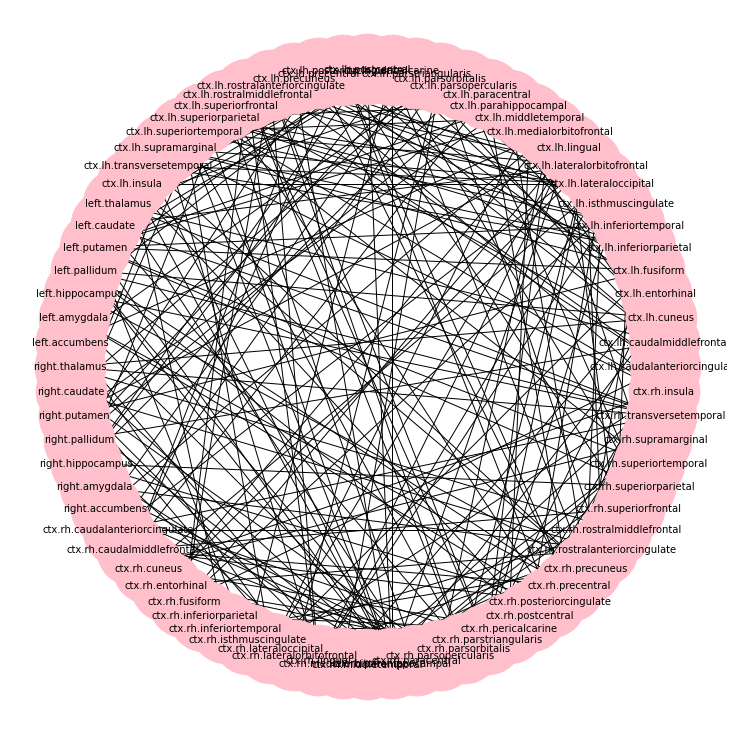

In [45]:
G_named_FA = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_named_FA.add_node(node_name)  

for node_id in model_fa.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_fa.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_FA.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_FA.number_of_nodes()}")
print(f"Número de aristas: {G_named_FA.number_of_edges()}")



plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_FA) 
nx.draw(G_named_FA, pos, with_labels=True, node_size=5000, node_color="pink", font_size=10)
plt.show()

Número de nodos: 76
Número de aristas: 272


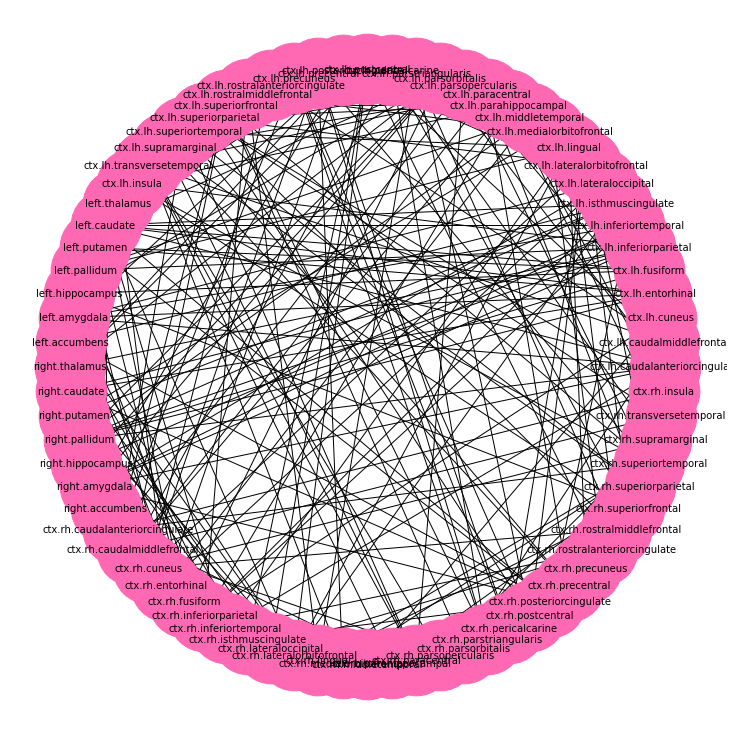

In [46]:
G_named_GM = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_named_GM.add_node(node_name) 

for node_id in model_GM.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_GM.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_GM.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_GM.number_of_nodes()}")
print(f"Número de aristas: {G_named_GM.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_GM)  # Disposición de los nodos
nx.draw(G_named_GM, pos, with_labels=True, node_size=5000, node_color="hotpink", font_size=10)
plt.show()

Número de nodos: 76
Número de aristas: 269


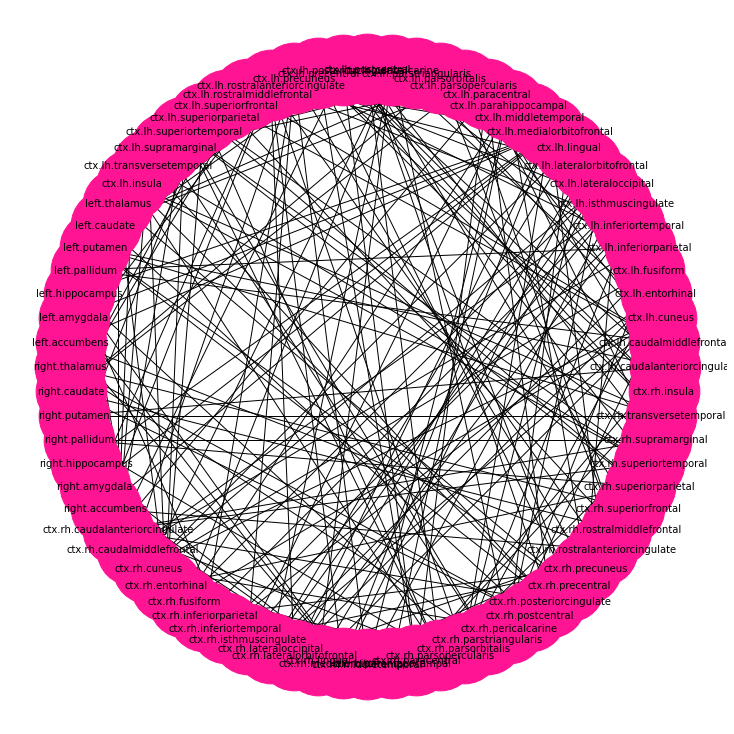

In [47]:
G_named_RS = nx.Graph()


for node_id, node_name in node_id_to_name.items():
    G_named_RS.add_node(node_name)  # Añadir el nodo usando su nombre

for node_id in model_RS.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_RS.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_RS.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_RS.number_of_nodes()}")
print(f"Número de aristas: {G_named_RS.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_RS)  
nx.draw(G_named_RS, pos, with_labels=True, node_size=5000, node_color="deeppink", font_size=10)
plt.show()